In [ ]:
%pip install tensorflow
%pip install seaborn
%pip install scikit-learn

In [ ]:
import os

#base settings

baseDir = "./datasets/FruitDataset/"
os.listdir(baseDir)

batch_size = 32 
image_size = 224

In [113]:
import tensorflow as tf

# Load training and validation datasets
train_ds = tf.keras.utils.image_dataset_from_directory(
    baseDir + "train",
    labels="inferred", #figure out the values
    label_mode="categorical",  # Use categorical for multi-class classification
    image_size=(image_size,image_size),
    batch_size=batch_size,
    shuffle=True,
    seed=42            
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    baseDir + "dev",
    labels="inferred",
    label_mode="categorical",
    image_size=(image_size,image_size),
    batch_size=batch_size,
    shuffle=True,
    seed=42
)

# Test dataset (assuming separate directory for test data)
test_ds = tf.keras.utils.image_dataset_from_directory(
    baseDir + "test",
    labels="inferred",
    label_mode="categorical",
    image_size=(image_size,image_size),
    batch_size=batch_size,
    shuffle=False  # No shuffling for test set
)

print(train_ds.class_names)

Found 383 files belonging to 3 classes.
Found 109 files belonging to 3 classes.
Found 58 files belonging to 3 classes.
['Apple', 'Banana', 'Orange']


In [114]:
model = tf.keras.applications.EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation='softmax',
)

In [115]:
from tensorflow.keras import layers

# Freeze all layers in base model
model.trainable = False

# Add new layers on top of the base model
transfer_model = tf.keras.Sequential([
    model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation="relu"),
    layers.Dense(3, activation='softmax') 
])

Transfer Learning is something you do with Deep Networks. Ones with lots of layers. This is an example notebook on how transfer learning works. With shallow CNN models, transfer learning won't help you much because there aren't enough layers to work with.

In [116]:
transfer_model.summary()

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, None, None,     │     4,049,571 │
│                                 │ 1280)                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,213,926 (16.07 MB)

 Trainable params: 164,355 (642.01 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [117]:
#compile model

transfer_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
                  loss='categorical_crossentropy',  # Suitable for classification
                  metrics=['accuracy'])

In [118]:
epochs = 10
history = transfer_model.fit(train_ds, epochs=epochs, validation_data=val_ds)

Epoch 1/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 35s 619ms/step - accuracy: 0.2578 - loss: 1.1809 - val_accuracy: 0.3486 - val_loss: 1.1121
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 20s 424ms/step - accuracy: 0.4665 - loss: 1.0583 - val_accuracy: 0.5688 - val_loss: 0.9995
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 20s 425ms/step - accuracy: 0.6262 - loss: 0.9522 - val_accuracy: 0.6789 - val_loss: 0.9012
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 22s 463ms/step - accuracy: 0.7326 - loss: 0.8650 - val_accuracy: 0.7890 - val_loss: 0.8143
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 19s 404ms/step - accuracy: 0.8147 - loss: 0.7811 - val_accuracy: 0.8349 - val_loss: 0.7394
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 18s 383ms/step - accuracy: 0.8566 - loss: 0.7034 - val_accuracy: 0.8624 - val_loss: 0.6734
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 18s 385ms/step - accuracy: 0.8911 - loss: 0.6203 - val_accuracy: 0.8807 - val_loss: 0.6155
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 19s 393ms/step - accuracy: 0.8679 - loss: 0.5742 - val_accu

In [119]:
transfer_model.save("./models/efficientnet.keras")

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - accuracy: 0.8931 - loss: 0.4767


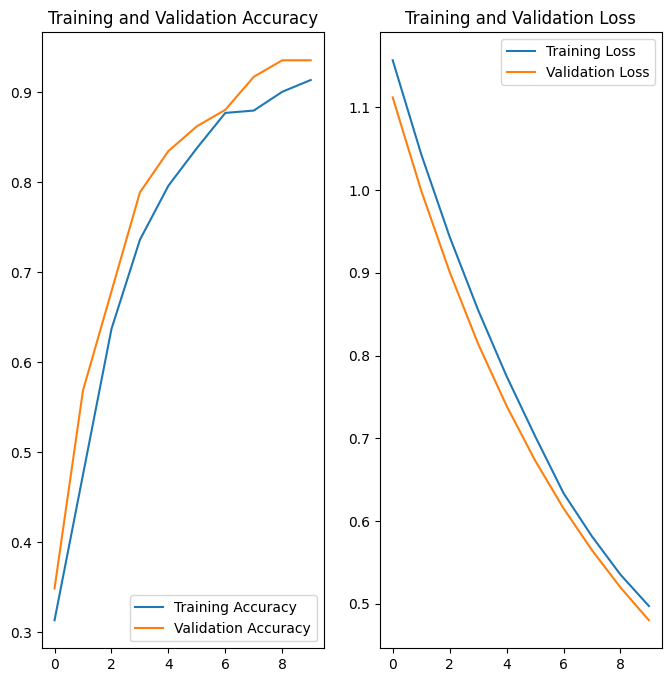

In [120]:
import matplotlib.pyplot as plt

transfer_model.evaluate(test_ds)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

2025-07-26 09:56:56.265716: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 755ms/step
Precision: 0.897
Recall (Sensitivity): 0.879
F1 Score: 0.877


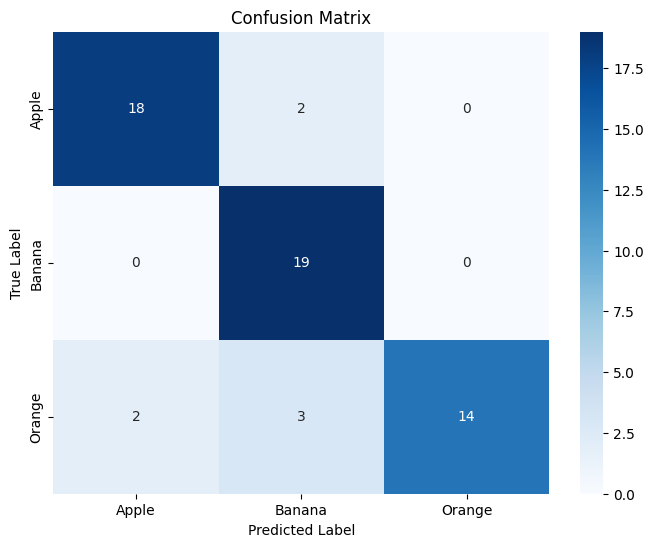

In [121]:
# Get predictions and true labels
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix

y_true = []

for images, labels in test_ds:
    y_true.extend(np.argmax(labels.numpy(), axis=1))
y_true = np.array(y_true)

y_pred_probs = transfer_model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

# Calculate precision, recall, f1-score (macro average)
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
print(f"Precision: {precision:.3f}")
print(f"Recall (Sensitivity): {recall:.3f}")
print(f"F1 Score: {f1:.3f}")

# Plot confusion matrix
class_names = train_ds.class_names
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
#prediction

import tensorflow as tf
import numpy as np

# === Settings ===
model_path = "./models/customCNNWithTFLearning.keras"            # Replace with your model path
image_path = "./images/test/orange.jpeg"        # Replace with your image path
class_names = ["Apple", "Banana", "Orange"]  # Your class labels

TLCNNModel = tf.keras.models.load_model(model_path)

# === Load & Preprocess Image ===
img = tf.keras.utils.load_img(image_path, target_size=(image_size,image_size))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, axis=0)      # Add batch dimension

# === Predict ===
predictions = TLCNNModel.predict(img_array)
predicted_class = np.argmax(predictions[0])
confidence = np.max(predictions[0])

# === Output ===
print(f"Predicted: {class_names[predicted_class]} ({confidence:.2f})")